In [1]:
#libraries
library(GO.db)
library(topGO)
library(org.Sc.sgd.db)
library(GOSemSim)
library(gridExtra)
library(GOSim)

Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

 

In [2]:
file <- "yeast_uetz"

ont <- "BP"
p <- 0.1

db <- org.Sc.sgd.db
mapping <- "org.Sc.sgd.db"
ID <- "ENSEMBL"

##load all community gene lists
setwd(sprintf("/home/david/Documents/ghsom/%s_hierarchy_communities_%s", file, p))

scGO <- godata(OrgDb = mapping, keytype = ID, ont = ont)

setOntology(ont, loadIC=TRUE)
setEvidenceLevel(evidences="all", organism=org.Sc.sgdORGANISM, gomap=org.Sc.sgdGO)

[1] "preparing gene to GO mapping data..."
[1] "preparing IC data..."


initializing GOSim package ...
-> retrieving GO information for all available genes for organism 'human' in GO database
-> filtering GO terms according to evidence levels 'all'
-> loading files with information content for corresponding GO category (human)
finished.
-> loading files with information content for corresponding GO category (human)
-> retrieving GO information for all available genes for organism 'Saccharomyces cerevisiae' in GO database
-> filtering GO terms according to evidence levels 'all'


In [3]:
generateMap <- function(filename){
    map <- as.matrix(read.csv(filename, sep=",", header = F))
    communities <- map[,1]
    map <- map[,2:ncol(map)]
    rownames(map) <- communities
    colnames(map) <- communities
    return (map)
}

In [8]:
#background gene list
backgroundFilename <- "all_genes.txt"
allGenes <- scan(backgroundFilename, character())

#shortest path files
shortestPathFiles  <- list.files(pattern="*shortest_path*")

#shortest paths list
shortestPaths <- lapply(shortestPathFiles, generateMap)
names(shortestPaths) <- sapply(names(shortestPaths), function(name) strsplit(name, "_")[[1]][[1]])

#communitiy assignemtns
assignments <- as.matrix(read.csv("assignment_matrix.csv", sep=",", header=F))
rownames(assignments) <- allGenes
colnames <- sapply(1:ncol(assignments), function(i) as.character(i-1))
colnames(assignments) <- colnames
    
allGenesInDB <- keys(db)

In [9]:
shortestPaths

,2,3,4,5,6,7,8,9,10,11,⋯,43,44,45,46,47,48,49,50,51,52
2,0,1,1,2,1,2,3,3,2,2,⋯,7,5,5,6,4,5,3,4,4,6
3,1,0,2,3,2,3,4,4,1,1,⋯,8,6,6,7,5,6,4,5,5,7
4,1,2,0,1,1,1,2,2,3,3,⋯,6,4,4,5,3,4,3,4,4,5
5,2,3,1,0,2,2,3,3,4,4,⋯,7,5,5,6,4,5,4,5,5,6
6,1,2,1,2,0,2,3,3,3,3,⋯,7,5,5,6,4,5,4,5,5,6
7,2,3,1,2,2,0,1,1,4,4,⋯,5,3,3,4,2,3,4,5,5,4
8,3,4,2,3,3,1,0,1,5,5,⋯,6,4,4,5,3,4,5,6,6,5
9,3,4,2,3,3,1,1,0,5,5,⋯,6,4,4,5,3,4,5,6,6,5
10,2,1,3,4,3,4,5,5,0,2,⋯,9,7,7,8,6,7,5,6,6,8
11,2,1,3,4,3,4,5,5,2,0,⋯,9,7,7,8,6,7,5,6,6,8


In [10]:
getDepth <- function(com) {
    return(which(apply(assignments, 2, function(i) any(i == com))))
}

getGenes <- function(com){
    return(names(which(assignments[,getDepth(com)] == com)))
}

getSubCommunities <- function(com){
    return(try(as.character(unique(assignments[getGenes(com), getDepth(com) + 1]))))
}

getSuperCommunity <- function(com){
    return(try(as.character(unique(assignments[getGenes(com), getDepth(com) - 1]))))
}

getShortestPath <- function(com){
    return (try(shortestPaths[[com]]))
}
                       
getNeighbours <- function(com){
    
    superCommunity <- getSuperCommunity(com)
    map <- getShortestPath(superCommunity)
    v <- map[com,] == 1
    return (names(v[v]))
    
}

In [11]:
communitySimilarity <- function(community) {
    geneSims <- mgeneSim(genes = getGenes(as.character(community)), 
                         semData = scGO, measure = "Wang", combine = "BMA", verbose=F)
    if (length(geneSims) > 1) {
        return(mean(geneSims[upper.tri(geneSims)]))
    } else {
        return (NaN)
    }
}

In [12]:
layerSimilarity <- function(layer) {
    communitiesSimilarity <- sapply(unique(assignments[,layer][assignments[,layer] != -1]), communitySimilarity)
    communitiesSimilarity <- communitiesSimilarity[!is.na(communitiesSimilarity)]
    return(mean(communitiesSimilarity))
}

In [ ]:
layerMeanSimilarities <- sapply(colnames, layerSimilarity)

In [ ]:
layerMeanSimilarities

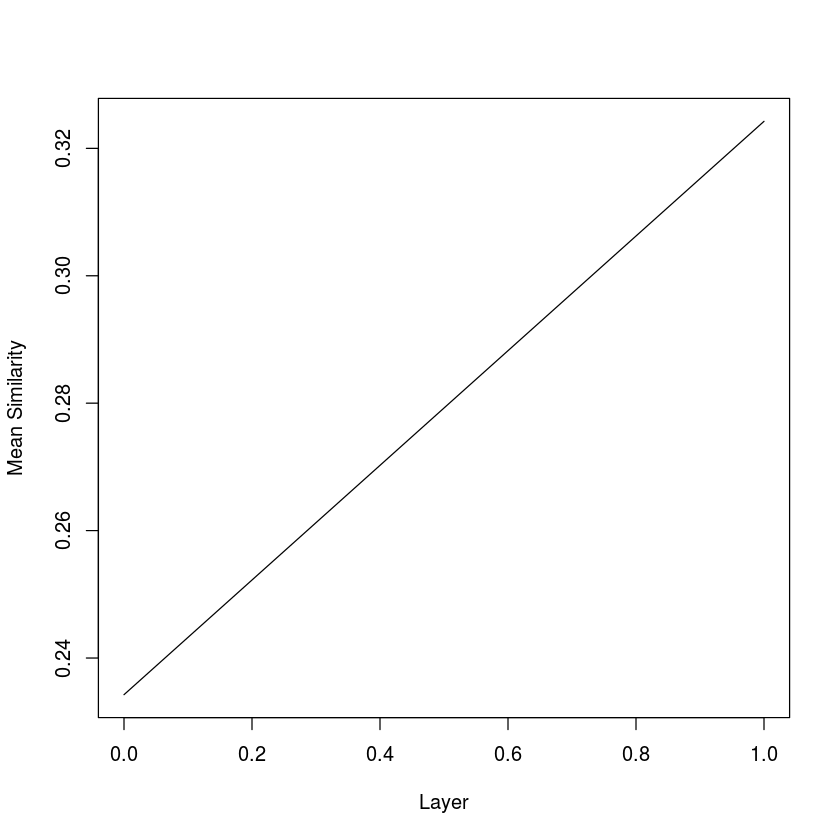

In [10]:
plot(colnames, layerMeanSimilarities, xlab="Layer", ylab="Mean Similarity", type = "l")

In [14]:
enrichmentResults <- sapply(1:max(assignments), function(i) {

    genesOfInterest <- getGenes(i)
    genesOfInterest <- genesOfInterest[genesOfInterest %in% allGenesInDB]
    GOenrichment(genesOfInterest, allGenesInDB, cutoff=0.05, method="weight01")
})


Building most specific GOs .....
	( 2909 GO terms found. )

Build GO DAG topology ..........
	( 5064 GO terms and 11404 relations. )

Annotating nodes ...............
	( 6419 genes annotated to the GO terms. )

			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 1848 nontrivial nodes
		 parameters: 
			 test statistic: fisher

	 Level 16:	3 nodes to be scored	(0 eliminated genes)

	 Level 15:	12 nodes to be scored	(0 eliminated genes)

	 Level 14:	33 nodes to be scored	(13 eliminated genes)

	 Level 13:	63 nodes to be scored	(116 eliminated genes)

	 Level 12:	93 nodes to be scored	(406 eliminated genes)

	 Level 11:	131 nodes to be scored	(804 eliminated genes)

	 Level 10:	190 nodes to be scored	(1400 eliminated genes)

	 Level 9:	232 nodes to be scored	(2023 eliminated genes)

	 Level 8:	234 nodes to be scored	(2704 eliminated genes)

	 Level 7:	245 nodes to be scored	(3775 eliminated genes)

	 Level 6:	254 nodes to be scored	(4476 eliminated genes)

	 Level 5:	195 nodes to 

In [15]:
rownames(enrichmentResults) <- c("terms","p-values","genes")
colnames(enrichmentResults) <- 1:max(assignments)

In [17]:
enrichmentResults["terms",]

,go_id,Term,Definition
131,GO:0000050,urea cycle,"The sequence of reactions by which arginine is synthesized from ornithine, then cleaved to yield urea and regenerate ornithine. The overall reaction equation is NH3 + CO2 + aspartate + 3 ATP + 2 H2O = urea + fumarate + 2 ADP + 2 phosphate + AMP + diphosphate."
137,GO:0000053,argininosuccinate metabolic process,"The chemical reactions and pathways involving argininosuccinate, 2-(N(omega)-arginino)succinate, an intermediate in the ornithine-urea cycle, where it is synthesized from citrulline and aspartate."
335,GO:0000132,establishment of mitotic spindle orientation,A cell cycle process that sets the alignment of mitotic spindle relative to other cellular structures.
459,GO:0000184,"nuclear-transcribed mRNA catabolic process, nonsense-mediated decay","The nonsense-mediated decay pathway for nuclear-transcribed mRNAs degrades mRNAs in which an amino-acid codon has changed to a nonsense codon; this prevents the translation of such mRNAs into truncated, and potentially harmful, proteins."
834,GO:0000288,"nuclear-transcribed mRNA catabolic process, deadenylation-dependent decay",A major pathway of degradation of nuclear-transcribed mRNAs that proceeds through a series of ordered steps that includes poly(A) tail shortening and that can regulate mRNA stability.
845,GO:0000290,deadenylation-dependent decapping of nuclear-transcribed mRNA,Cleavage of the 5'-cap of a nuclear mRNA triggered by shortening of the poly(A) tail to below a minimum functional length.
1129,GO:0000422,mitophagy,The autophagic process in which mitochondria are delivered to the vacuole and degraded in response to changing cellular conditions.
1247,GO:0000706,meiotic DNA double-strand break processing,The cell cycle process in which the 5' to 3' exonucleolytic resection of the DNA at the site of the break to form a 3' single-strand DNA overhang occurs. This takes place during meiosis.
1282,GO:0000722,telomere maintenance via recombination,Any recombinational process that contributes to the maintenance of proper telomeric length.
1283,GO:0000723,telomere maintenance,"Any process that contributes to the maintenance of proper telomeric length and structure by affecting and monitoring the activity of telomeric proteins, the length of telomeric DNA and the replication and repair of the DNA. These processes includes those that shorten, lengthen, replicate and repair the telomeric DNA sequences."


In [14]:
mapSimilarity <- function(mapID) {
    map <- getShortestPath(as.character(mapID))
    if (is.null(map)) return (NaN)
    communities <- sapply(rownames(map), function(rowname) getGenes(rowname))
    communitySimilarities <- mclusterSim(clusters = communities, semData = scGO, measure = "Wang", combine = "BMA")
    return(mean(communitySimilarities[upper.tri(communitySimilarities)]))
}

In [15]:
similarityOfAllMapsOnLayer <- function(layer) {
    mapSimilarities <- sapply(unique(assignments[,layer][assignments[,layer] != -1]), mapSimilarity)
    mapSimilarities <- mapSimilarities[!is.na(mapSimilarities)]
    return(mean(mapSimilarities))
}

In [16]:
layerMeanMapSimilarities <- sapply(colnames[1:length(colnames)-1], similarityOfAllMapsOnLayer)

ERROR: Error in clusters[[i]]: subscript out of bounds


In [ ]:
sho

In [26]:
getShortestPath("1")

In [17]:
getNeighbours("4")

ERROR: Error in map[com, ]: incorrect number of dimensions


In [62]:
numSharedTerms <- function(c1, c2) {
    return(length(intersect(names(enrichmentResults[["p-values", c1]]),
                            names(enrichmentResults[["p-values", c2]]))))
}

In [18]:
getShortestPath("1")

In [19]:
assignments

,0,1
YGR046W,1,34
YCL046W,1,28
YJL030W,1,24
YBR057C,1,12
YKR026C,1,16
YFL056C,1,7
YFL061W,1,10
YDR174W,1,33
YLR303W,1,10
YPL211W,1,4


In [65]:
sapply(as.character(2:7), function(i) sapply(as.character(2:7), function(j) numSharedTerms(i, j)))

,2,3,4,5,6,7
2,51,0,0,0,2,2
3,0,51,1,1,1,0
4,0,1,36,1,0,1
5,0,1,1,32,0,0
6,2,1,0,0,41,0
7,2,0,1,0,0,40


In [66]:
getShortestPath("7")

,15,16
15,0,1
16,1,0


In [58]:
intersect(names(enrichmentResults[["p-values", "4"]]), names(enrichmentResults[["p-values", "2"]]))

character(0)

In [59]:
intersect(names(enrichmentResults[["p-values", "4"]]), names(enrichmentResults[["p-values", "14"]]))

[1] "GO:0015031" "GO:0006999" "GO:0001113" "GO:0006913" "GO:0046777"
 [6] "GO:0072417" "GO:0032147" "GO:0007118" "GO:0051028" "GO:0060188"
[11] "GO:0030474"

In [60]:
intersect(names(enrichmentResults[["p-values", "4"]]), names(enrichmentResults[["p-values", "13"]]))

[1] "GO:0032880" "GO:0007032" "GO:0036010" "GO:0006810" "GO:0015693"

In [61]:
intersect(names(enrichmentResults[["p-values", "13"]]), names(enrichmentResults[["p-values", "14"]]))

character(0)

In [22]:
select(GO.db, keys=names(enrichmentResults[["p-values", 4]]), columns=c("GOID", "TERM", "DEFINITION"))

'select()' returned 1:1 mapping between keys and columns


GOID,TERM,DEFINITION
GO:0032258,CVT pathway,"A constitutive biosynthetic process that occurs under nutrient-rich conditions, in which two resident vacuolar hydrolases, aminopeptidase I and alpha-mannosidase, are sequestered into vesicles; these vesicles are transported to, and then fuse with, the vacuole. This pathway is mostly observed in yeast."
GO:0000045,autophagosome assembly,"The formation of a double membrane-bounded structure, the autophagosome, that occurs when a specialized membrane sac, called the isolation membrane, starts to enclose a portion of the cytoplasm."
GO:0000422,mitophagy,The autophagic process in which mitochondria are delivered to the vacuole and degraded in response to changing cellular conditions.
GO:0015031,protein transport,"The directed movement of proteins into, out of or within a cell, or between cells, by means of some agent such as a transporter or pore."
GO:0032880,regulation of protein localization,"Any process that modulates the frequency, rate or extent of any process in which a protein is transported to, or maintained in, a specific location."
GO:0006606,protein import into nucleus,The directed movement of a protein from the cytoplasm to the nucleus.
GO:0030242,pexophagy,The process in which peroxisomes are delivered to the vacuole and degraded in response to changing nutrient conditions.
GO:0007032,endosome organization,"A process that is carried out at the cellular level which results in the assembly, arrangement of constituent parts, or disassembly of endosomes."
GO:0007034,vacuolar transport,"The directed movement of substances into, out of or within a vacuole."
GO:0007035,vacuolar acidification,"Any process that reduces the pH of the vacuole, measured by the concentration of the hydrogen ion."


In [25]:
select(GO.db, keys=names(enrichmentResults[["p-values", 14]]), columns=c("GOID", "TERM", "DEFINITION"))

'select()' returned 1:1 mapping between keys and columns


GOID,TERM,DEFINITION
GO:0046777,protein autophosphorylation,"The phosphorylation by a protein of one or more of its own amino acid residues (cis-autophosphorylation), or residues on an identical protein (trans-autophosphorylation)."
GO:0006913,nucleocytoplasmic transport,The directed movement of molecules between the nucleus and the cytoplasm.
GO:0000920,cell separation after cytokinesis,The process of physically separating progeny cells after cytokinesis; this may involve enzymatic digestion of septum or cell wall components.
GO:0001113,transcriptional open complex formation at RNA polymerase II promoter,Any process involved in the melting of the DNA hybrid of the core promoter region within the transcriptional closed complex of an RNA polymerase II preinitiation complex (PIC) to produce an open complex where the DNA duplex around the transcription initiation site is unwound to form the transcription bubble.
GO:0006607,NLS-bearing protein import into nucleus,"The directed movement of a protein bearing a nuclear localization signal (NLS) from the cytoplasm into the nucleus, across the nuclear membrane."
GO:0042981,regulation of apoptotic process,Any process that modulates the occurrence or rate of cell death by apoptotic process.
GO:0070816,phosphorylation of RNA polymerase II C-terminal domain,"The process of introducing a phosphate group on to an amino acid residue in the C-terminal domain of RNA polymerase II. Typically, this occurs during the transcription cycle and results in production of an RNA polymerase II enzyme where the carboxy-terminal domain (CTD) of the largest subunit is extensively phosphorylated, often referred to as hyperphosphorylated or the II(0) form. Specific types of phosphorylation within the CTD are usually associated with specific regions of genes, though there are exceptions. The phosphorylation state regulates the association of specific complexes such as the capping enzyme or 3'-RNA processing machinery to the elongating RNA polymerase complex."
GO:0031990,mRNA export from nucleus in response to heat stress,"The directed movement of mRNA from the nucleus to the cytoplasm during a heat stimulus, a temperature stimulus above the optimal temperature for the organism; in particular, a process that enables an organism withstand exposure to temperatures that would otherwise lethally impair poly(A)+ mRNA-nucleus export."
GO:0031098,stress-activated protein kinase signaling cascade,A series of molecular signals in which a stress-activated protein kinase (SAPK) cascade relays one or more of the signals.
GO:0007039,protein catabolic process in the vacuole,"The chemical reactions and pathways resulting in the breakdown of a protein in the vacuole, usually by the action of vacuolar proteases."


In [23]:
getSubCommunities(4)

[1] "14" "10" "12" "11" "13"

In [20]:
layerMeanMapSimilarities

0         1         2 
0.6410667 0.4615778 0.3652194

In [ ]:
getDistance <- function(c1, c2) {
    
    m1 <- getSuperCommunity(c1)
    m2 <- getSuperCommunity(c2)
    
    if (m1 == m2) return(getShortestPath(m1)[c1, c2])
        
    d1 <- getDepth(c1)
    d2 <- getDepth(c2)
        
    if (d1 == d2) return (2 + getDistance(m1, m2))
        
    if (d1 > d2) return (1 + getDistance(m1, c2))
        
    if (d2 > d1) return (1 + getDistance(c1, m2))
    
}

In [78]:
distances <- sapply(as.character(2:max(assignments)), function(i)
    sapply(as.character(2:max(assignments)), function(j) {
        return(getDistance(i, j))
    }))

[1] "attempting 2 2"
[1] "attempting 2 3"
[1] "attempting 2 4"
[1] "attempting 2 5"
[1] "attempting 2 6"
[1] "attempting 2 7"
[1] "attempting 2 8"
[1] "attempting 2 9"
[1] "attempting 2 10"
[1] "attempting 2 11"
[1] "attempting 2 12"
[1] "attempting 2 13"
[1] "attempting 2 14"
[1] "attempting 2 15"
[1] "attempting 2 16"
[1] "attempting 2 17"
[1] "attempting 2 18"
[1] "attempting 2 19"
[1] "attempting 2 20"
[1] "attempting 2 21"
[1] "attempting 2 22"
[1] "attempting 2 23"
[1] "attempting 2 24"
[1] "attempting 2 25"
[1] "attempting 2 26"
[1] "attempting 2 27"
[1] "attempting 2 28"
[1] "attempting 2 29"
[1] "attempting 2 30"
[1] "attempting 2 31"
[1] "attempting 2 32"
[1] "attempting 2 33"
[1] "attempting 2 34"
[1] "attempting 2 35"
[1] "attempting 2 36"
[1] "attempting 2 37"
[1] "attempting 2 38"
[1] "attempting 2 39"
[1] "attempting 2 40"
[1] "attempting 2 41"
[1] "attempting 2 42"
[1] "attempting 2 43"
[1] "attempting 2 44"
[1] "attempting 2 45"
[1] "attempting 2 46"
[1] "attempting 2 

In [80]:
head(distances)

,2,3,4,5,6,7,8,9,10,11,⋯,49,50,51,52,53,54,55,56,57,58
2,0,1,1,2,2,1,3,2,2,3,⋯,4,3,3,3,3,3,3,5,5,5
3,1,0,1,1,1,1,2,1,1,2,⋯,3,3,3,3,3,3,3,4,4,4
4,1,1,0,1,2,2,2,2,2,3,⋯,4,4,4,4,4,4,4,5,5,5
5,2,1,1,0,1,2,1,2,2,3,⋯,3,4,4,4,4,4,4,4,4,4
6,2,1,2,1,0,2,1,1,2,2,⋯,2,4,4,4,4,4,4,3,3,3
7,1,1,2,2,2,0,3,2,2,3,⋯,4,2,2,2,2,2,2,5,5,5


In [84]:
similarities <- sapply(2:max(assignments), function(i)
    sapply(2:max(assignments), function(j) {
        return(clusterSim(cluster1 = geneCommunities[[i]], 
                          cluster2 = geneCommunities[[j]], semData = scGO, measure = "Wang", combine = "BMA"))
    }))

In [86]:
head(similarities)

1.000,0.336,0.661,0.620,0.617,0.662,0.578,0.551,0.626,0.418,⋯,0.443,0.177,0.528,0.286,0.418,0.319,0.212,0.436,0.270,0.420
0.336,1.000,0.318,0.355,0.314,0.324,0.303,0.323,0.433,0.389,⋯,0.339,0.234,0.276,0.375,0.394,0.296,0.178,0.285,0.252,0.221
0.661,0.318,1.000,0.627,0.675,0.639,0.639,0.485,0.594,0.398,⋯,0.477,0.170,0.508,0.350,0.444,0.303,0.238,0.467,0.242,0.421
0.620,0.355,0.627,1.000,0.626,0.630,0.604,0.452,0.557,0.412,⋯,0.408,0.198,0.501,0.323,0.432,0.350,0.222,0.432,0.238,0.361
0.617,0.314,0.675,0.626,1.000,0.640,0.653,0.499,0.593,0.469,⋯,0.528,0.184,0.493,0.325,0.433,0.318,0.212,0.561,0.358,1.000
0.662,0.324,0.639,0.630,0.640,1.000,0.586,0.424,0.588,0.451,⋯,0.439,0.189,0.597,0.305,0.455,0.359,0.269,0.423,0.265,0.388


In [14]:
uniprots <- sapply(1:max(assignments), function(i) {
    orfs <- getGenes(i)
    orfs <- orfs[orfs %in% allGenesInDB]
    return(as.character(org.Sc.sgdUNIPROT[orfs]))
})

Warning message in .local(x, ...):
“returned vector has duplicated names”Warning message in .local(x, ...):
“returned vector has duplicated names”Warning message in .local(x, ...):
“returned vector has duplicated names”Warning message in .local(x, ...):
“returned vector has duplicated names”

In [15]:
uniprots[1]

[[1]]
 YAL032C  YAL040C  YBL007C  YBR057C  YBR094W  YBR133C  YBR196C  YBR221C 
"P28004" "P13365" "P32790" "P38236" "P38254" "P38274" "P12709" "P32473" 
 YBR252W  YBR270C  YBR274W  YCL054W  YCL055W  YCR011C  YCR050C  YCR086W 
"P33317" "P38346" "P38147" "P25582" "P25583" "P25371" "P25630" "P25651" 
 YDL002C  YDL012C  YDL013W  YDL017W  YDL088C  YDL110C  YDL111C  YDL154W 
"Q03435" "Q12489" "P32828" "P06243" "Q05166" "Q12513" "Q12277" "Q12175" 
 YDL160C  YDL165W  YDL203C  YDL215C  YDL236W  YDL246C  YDR054C  YDR061W 
"P39517" "P06100" "Q07622" "P33327" "P19881" "Q07786" "P14682" "Q12298" 
 YDR078C  YDR106W  YDR122W  YDR148C  YDR151C  YDR167W  YDR174W  YDR201W 
"P38957" "Q04549" "P13185" "P19262" "P47976" "Q12030" "Q03973" "Q03954" 
 YDR206W  YDR207C  YDR214W  YDR273W  YDR311W  YDR315C  YDR326C  YDR383C 
"Q03466" "P39001" "Q12449" "Q05610" "P32776" "Q06667" "Q06681" "Q12493" 
 YDR439W  YDR469W  YDR477W  YDR503C  YDR510W  YEL015W  YEL023C  YEL062W 
"Q04087" "Q03323" "P06782" "Q04396" "Q12306" "P39998" "P39992" "P39923" 
 YER027C  YER065C  YER079W  YER092W  YER105C  YER116C  YER179W  YFL061W 
"Q04739" "P28240" "P40052" "P40060" "P40064" "P40072" "P25453" "P0CH63" 
 YFL061W  YFR002W  YFR033C  YFR047C  YFR052W  YFR057W  YGL025C  YGL112C 
"P0CH64" "P34077" "P00127" "P43619" "P32496" "P43625" "P40356" "P53040" 
 YGL115W  YGL116W  YGL122C  YGL145W  YGL150C  YGL153W  YGL158W  YGL170C 
"P12904" "P26309" "P32505" "P33891" "P53115" "P53112" "P38622" "P45819" 
 YGL172W  YGL175C  YGL180W  YGL192W  YGL208W  YGL221C  YGL229C  YGL238W 
"Q02199" "P46946" "P53104" "P41833" "P34164" "P53081" "P53036" "P33307" 
 YGR014W  YGR024C  YGR046W  YGR057C  YGR058W  YGR099W  YGR117C  YGR119C 
"P32334" "P53215" "P53230" "P53237" "P53238" "P53038" "P53270" "P48837" 
 YGR120C  YGR136W  YGR155W  YGR158C  YGR253C  YGR268C  YHL006C  YHL009C 
"P53271" "P53281" "P32582" "P48240" "P32379" "P40325" "P38751" "P38749" 
 YHL046C  YHR016C  YHR032W  YHR057C  YHR060W  YHR102W  YHR128W  YHR129C 
"P38725" "P32793" "P38767" "P23285" "P38784" "P38692" "P18562" "P38696" 
 YHR140W  YHR158C  YIL013C  YIL065C  YIL105C  YIL132C  YIL144W  YIL172C 
"P38842" "P38853" "P40550" "P40515" "P40485" "P40465" "P40460" "P0CW40" 
 YIL172C  YJL013C  YJL030W  YJL041W  YJL048C  YJL057C  YJL065C  YJL088W 
"P0CW41" "P47074" "P40958" "P14907" "P47049" "P47042" "P40366" "P05150" 
 YJL092W  YJL110C  YJL178C  YJL184W  YJR034W  YJR072C  YJR091C  YJR117W 
"P12954" "P42944" "P46989" "P46984" "Q02772" "P47122" "P47135" "P47154" 
 YJR122W  YJR133W  YJR159W  YKL012W  YKL015W  YKL028W  YKL039W  YKL061W 
"P47158" "P47165" "P35497" "P33203" "P25502" "P36100" "P32857" "P35727" 
 YKL075C  YKL090W  YKL103C  YKL130C  YKL204W  YKR026C  YKR037C  YKR062W 
"P36083" "P36075" "P14904" "P36068" "P36041" "P14741" "P36131" "P36145" 
 YLL046C  YLR015W  YLR046C  YLR113W  YLR150W  YLR243W  YLR258W  YLR264W 
"P32385" "P43132" "Q12253" "P32485" "P39015" "Q06543" "P27472" "P0C0X0" 
 YLR291C  YLR303W  YLR305C  YLR315W  YLR321C  YLR323C  YLR345W  YLR376C 
"P32502" "P06106" "P37297" "Q06162" "Q06168" "P53769" "Q06137" "Q12318" 
 YLR392C  YLR423C  YLR432W  YLR433C  YLR447C  YML015C  YML028W  YML031W 
"P18634" "Q06410" "P50095" "P23287" "P32366" "Q04226" "P34760" "P32500" 
 YML114C  YMR068W  YMR102C  YMR129W  YMR153W  YMR180C  YMR181C  YMR224C 
"Q03750" "Q04749" "Q03177" "P39685" "Q03790" "Q03220" "Q03231" "P32829" 
 YMR226C  YMR236W  YMR255W  YMR267W  YMR269W  YMR309C  YMR314W  YNL021W 
"Q05016" "Q05027" "Q04839" "P28239" "Q03525" "P32497" "P40302" "P53973" 
 YNL023C  YNL047C  YNL086W  YNL091W  YNL118C  YNL122C  YNL154C  YNL164C 
"P53971" "P53955" "P48232" "P53935" "P53550" "P53921" "P23292" "P53892" 
 YNL189W  YNL199C  YNL201C  YNL218W  YNL236W  YNL244C  YNL288W  YNR029C 
"Q02821" "Q01722" "P40164" "P40151" "P32259" "P32911" "P53829" "P53729" 
 YNR048W  YOL020W  YOL058W  YOL082W  YOL105C  YOL123W  YOL130W  YOL149W 
"P53740" "P38967" "P22768" "P35193" "Q12215" "Q99383" "Q08269" "Q12517" 
 YOR006C  YOR026W  YOR036W  YOR047C  YOR062C  YOR078

In [12]:
g <- getGenes(2)[getGenes(2) %in% allGenesInDB]

In [13]:
org.Sc.sgdUNIPROT[g]

UNIPROT submap for Yeast (object of class "AnnDbBimap")